In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt"

In [2]:
from pathlib import Path

folder_path = Path(DATA_PATH)
all_files = [file for file in folder_path.rglob('*') if file.is_file()]

print(all_files)

[PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw3.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/gene.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/phenotype.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/fraw.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/cot.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl')]


In [3]:
def clean_answer(answer):
    # answer = answer.split("\n")[0]
    # answer = answer.replace("$", "").strip()
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

In [4]:
def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"

In [5]:
def cal_acc(answer, ground_truth):
    if answer == ground_truth:
        acc_score = 1
    else:
        acc_score = 0

    return acc_score

In [7]:
def normalize_uncertainty_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    
    if max_score == min_score:
        return [0.0 for _ in scores]
    
    return [(s - min_score) / (max_score - min_score) for s in scores]


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def create_calibration_plot(uncertainty_scores, accuracies, model_name):
    confidence_scores = normalize_uncertainty_scores(uncertainty_scores)
    
    bin_edges = np.linspace(0, 1, 11)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    bin_accuracies = np.zeros(len(bin_edges) - 1)
    bin_counts = np.zeros(len(bin_edges) - 1)
    
    for confidence, accuracy in zip(confidence_scores, accuracies):
        if confidence == 1.0:
            bin_idx = len(bin_edges) - 2
        else:
            bin_idx = int(confidence * 10)
        
        bin_accuracies[bin_idx] += accuracy
        bin_counts[bin_idx] += 1
    
    for i in range(len(bin_accuracies)):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
    
    perfect_calibration = bin_centers
    error = np.sum(np.abs(bin_accuracies - perfect_calibration) * bin_counts) / np.sum(bin_counts)
    error = error
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    bars = ax.bar(bin_centers, bin_accuracies, width=0.08, color='blue', edgecolor='black', label='Outputs')
    
    for i, (center, acc) in enumerate(zip(bin_centers, bin_accuracies)):
        if acc < center:
            ax.bar(center, center - acc, bottom=acc, width=0.08, color='lightpink', 
                  edgecolor='red', hatch='///', alpha=0.7, label='Gap' if i==0 else "")
        elif acc > center:
            ax.bar(center, acc - center, bottom=center, width=0.08, color='lightpink',
                  edgecolor='red', hatch='///', alpha=0.7, label='Gap' if i==0 else "")
        
        count = int(bin_counts[i])
        ax.text(center, max(acc + 0.03, center + 0.03), f'n={count}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax.plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='gray')
    
    ax.text(0.5, 0.2, f"Error={error}", bbox=dict(facecolor='lightgray', alpha=0.8), fontsize=12)
    
    ax.set_title(f'Calibration Plot for {model_name}')
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()
    
    plt.show()  
    
    return error


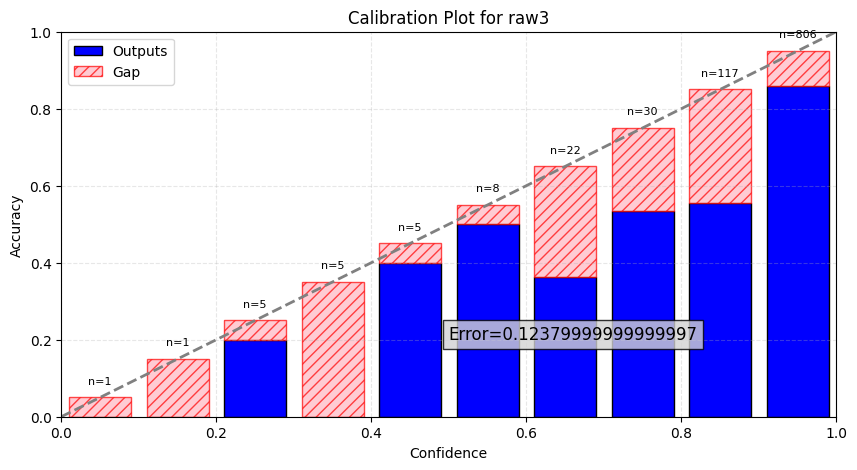

File: raw3, Calibration Error: 0.12379999999999997


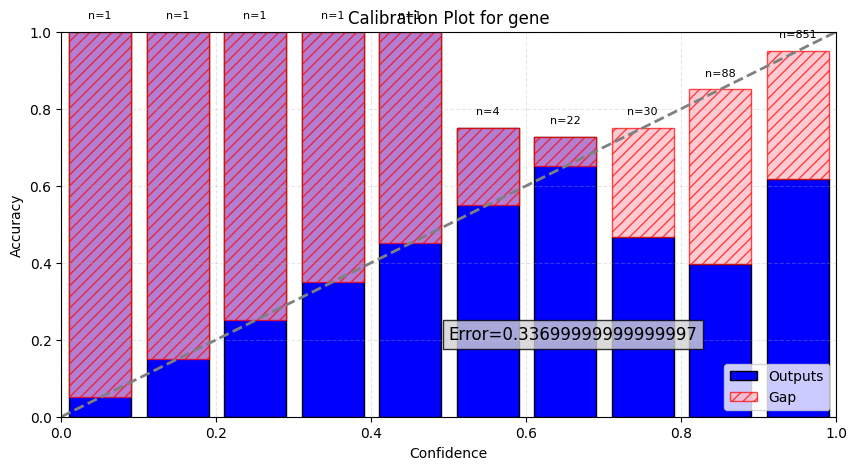

File: gene, Calibration Error: 0.33699999999999997


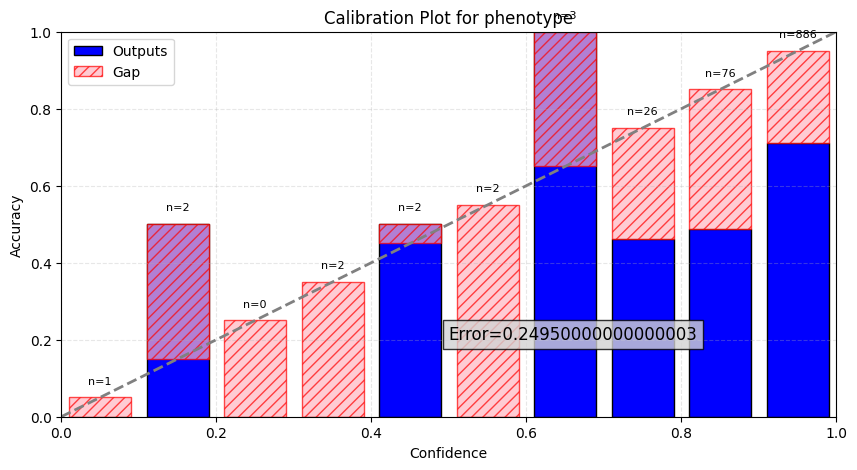

File: phenotype, Calibration Error: 0.24950000000000003


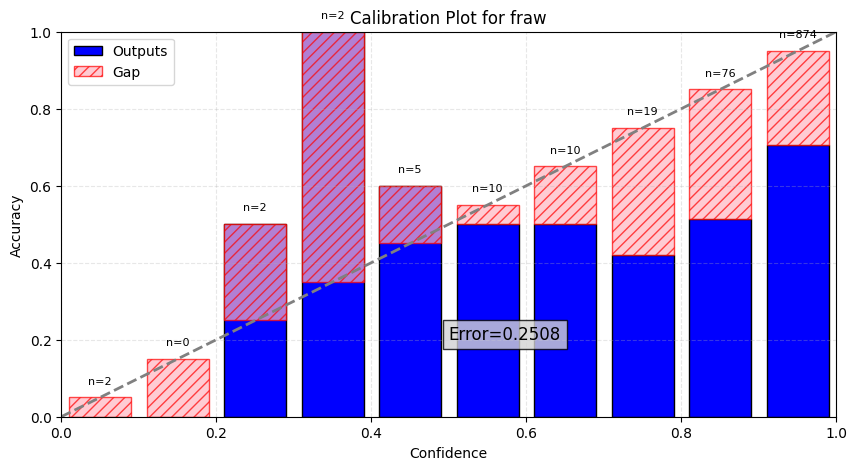

File: fraw, Calibration Error: 0.2508


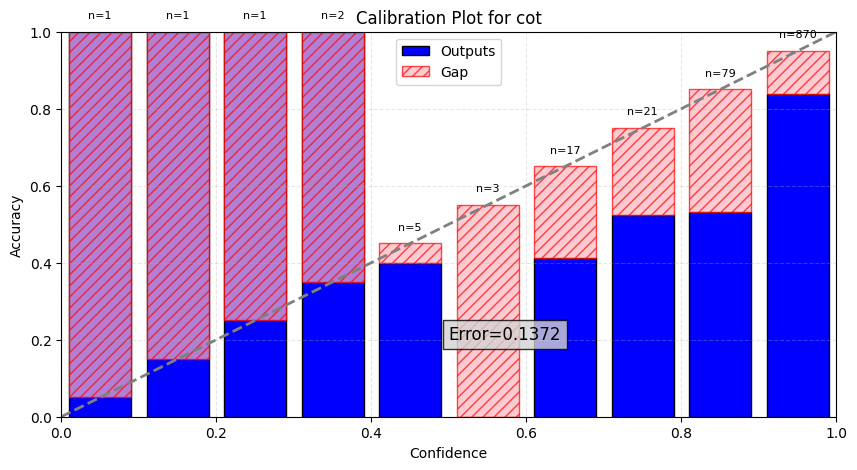

File: cot, Calibration Error: 0.1372


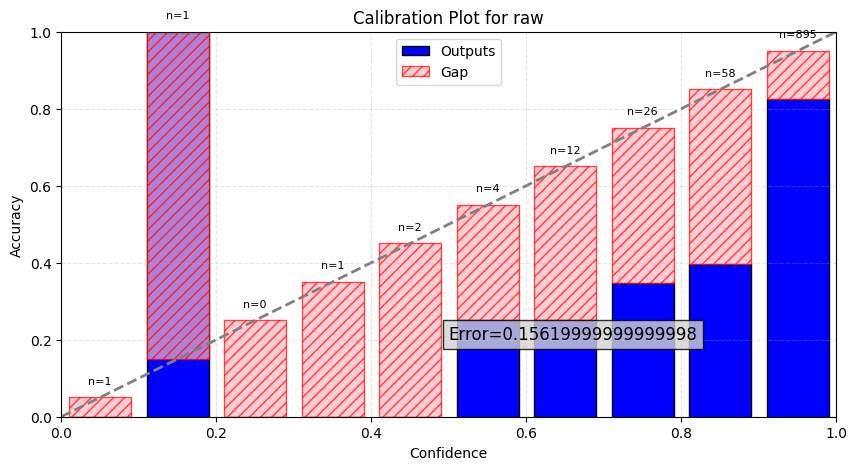

File: raw, Calibration Error: 0.15619999999999998


In [9]:
import jsonlines


for file in all_files:
    file_path = os.path.join(folder_path, file)
    f_data = []
    file_uncertainties = []
    file_accuracies = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            f_data.append(obj)
            
    for line in f_data:
        answer = line['answer']
        groundth_truth = return_ground_truth(line['label'])
        if isinstance(answer, list):
            answer = answer[0]
        response = clean_answer(answer['output'])
        logprobs = answer['logprobs']
        tokens = logprobs['tokens']
        if response == None:
            continue

        response_prob = 0
        for tk in tokens:
            if response in tk.upper():
                response_prob = logprobs['token_logprobs'][tokens.index(tk)]

        acc_score = cal_acc(response, groundth_truth)

        file_uncertainties.append(response_prob)
        file_accuracies.append(acc_score)
    
    filname = str(file).split("/")[-1]
    file_model_name = filname.split(".")[0]
    file_error = create_calibration_plot(file_uncertainties, file_accuracies, file_model_name)
    print(f"File: {file_model_name}, Calibration Error: {file_error}")


In [10]:
import jsonlines
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for file in all_files:
    file_path = os.path.join(folder_path, file)
    f_data = []
    file_uncertainties = []
    file_accuracies = []
    
    all_predictions = []
    all_ground_truths = []
    
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            f_data.append(obj)
            
    for line in f_data:
        answer = line['answer']
        groundth_truth = return_ground_truth(line['label'])
        if isinstance(answer, list):
            answer = answer[0]
        response = clean_answer(answer['output'])
        logprobs = answer['logprobs']
        tokens = logprobs['tokens']
        if response == None:
            continue

        response_prob = 0
        for tk in tokens:
            if response in tk.upper():
                response_prob = logprobs['token_logprobs'][tokens.index(tk)]

        acc_score = cal_acc(response, groundth_truth)
        
        all_predictions.append(response)
        all_ground_truths.append(groundth_truth)

        file_uncertainties.append(response_prob)
        file_accuracies.append(acc_score)
    
    accuracy = sum(file_accuracies) / len(file_accuracies) if file_accuracies else 0
    
    precision = precision_score(all_ground_truths, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_ground_truths, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_ground_truths, all_predictions, average='macro', zero_division=0)
    
    filename = str(file).split("/")[-1]
    file_model_name = filename.split(".")[0]
    
    print(f"File: {file_model_name}")
    print(f"Calibration Error: {file_error}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("----------------------------")

File: raw3
Calibration Error: 0.15619999999999998
Accuracy: 0.7880
Precision: 0.7925
Recall: 0.7880
F1 Score: 0.7872
----------------------------
File: gene
Calibration Error: 0.15619999999999998
Accuracy: 0.5990
Precision: 0.7726
Recall: 0.5990
F1 Score: 0.5231
----------------------------
File: phenotype
Calibration Error: 0.15619999999999998
Accuracy: 0.6850
Precision: 0.7759
Recall: 0.6850
F1 Score: 0.6567
----------------------------
File: fraw
Calibration Error: 0.15619999999999998
Accuracy: 0.6790
Precision: 0.7634
Recall: 0.6790
F1 Score: 0.6511
----------------------------
File: cot
Calibration Error: 0.15619999999999998
Accuracy: 0.7960
Precision: 0.8003
Recall: 0.7960
F1 Score: 0.7953
----------------------------
File: raw
Calibration Error: 0.15619999999999998
Accuracy: 0.7760
Precision: 0.7809
Recall: 0.7760
F1 Score: 0.7750
----------------------------



Model: raw3
Confusion Matrix:
          | Predicted NO | Predicted YES |
----------------------------------------
Actual NO  |         425 |            75 |
Actual YES |         137 |           363 |

Metrics:
Accuracy: 0.7880
Precision: 0.8288
Recall: 0.7260
F1 Score: 0.7740
High Confidence Calibration Error: 0.1119

Model: gene
Confusion Matrix:
          | Predicted NO | Predicted YES |
----------------------------------------
Actual NO  |         499 |             1 |
Actual YES |         400 |           100 |

Metrics:
Accuracy: 0.5990
Precision: 0.9901
Recall: 0.2000
F1 Score: 0.3328
High Confidence Calibration Error: 0.3470

Model: phenotype
Confusion Matrix:
          | Predicted NO | Predicted YES |
----------------------------------------
Actual NO  |         486 |            14 |
Actual YES |         301 |           199 |

Metrics:
Accuracy: 0.6850
Precision: 0.9343
Recall: 0.3980
F1 Score: 0.5582
High Confidence Calibration Error: 0.2635

Model: fraw
Confusion Matrix:
    

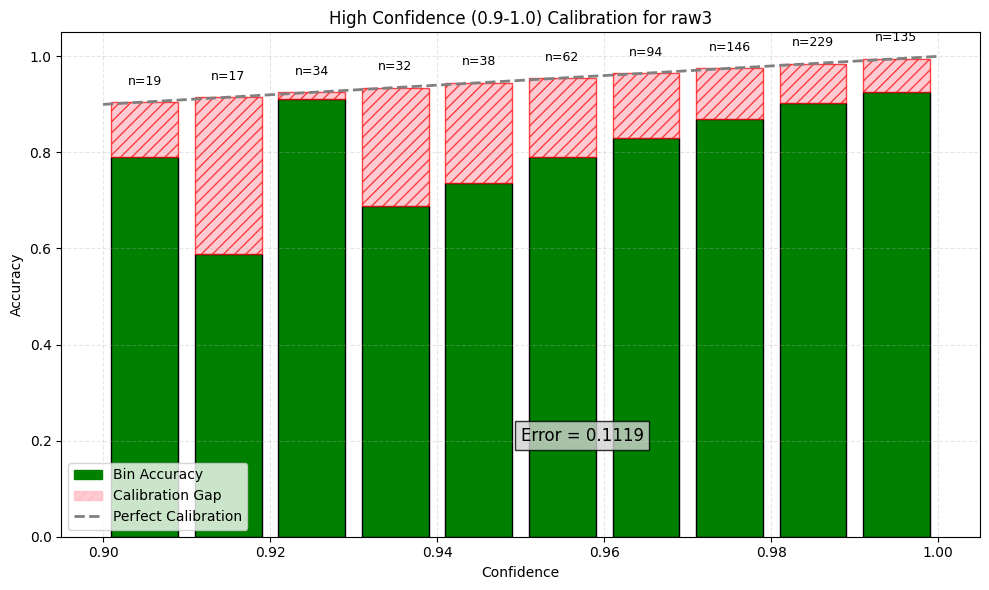

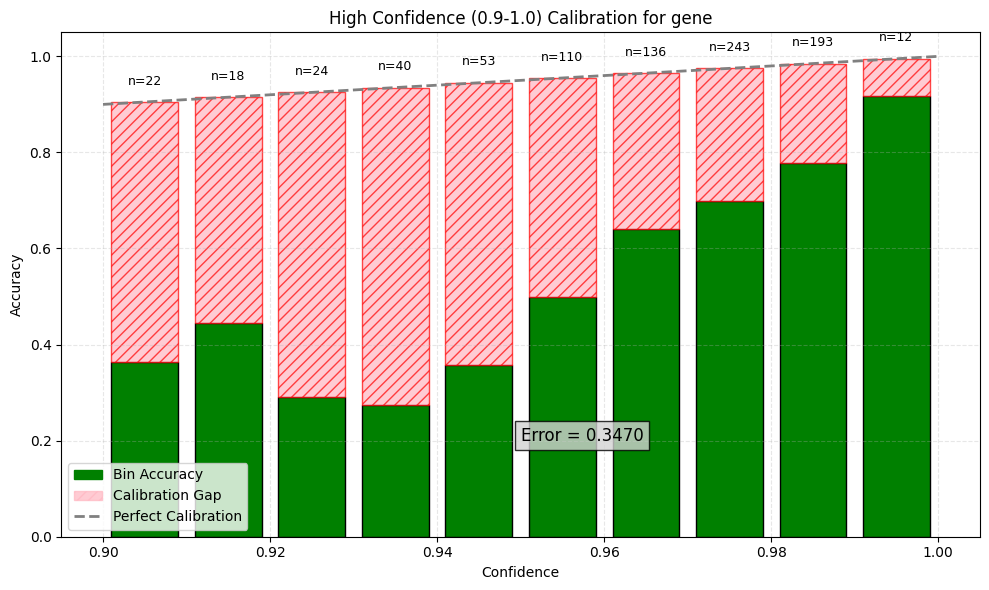

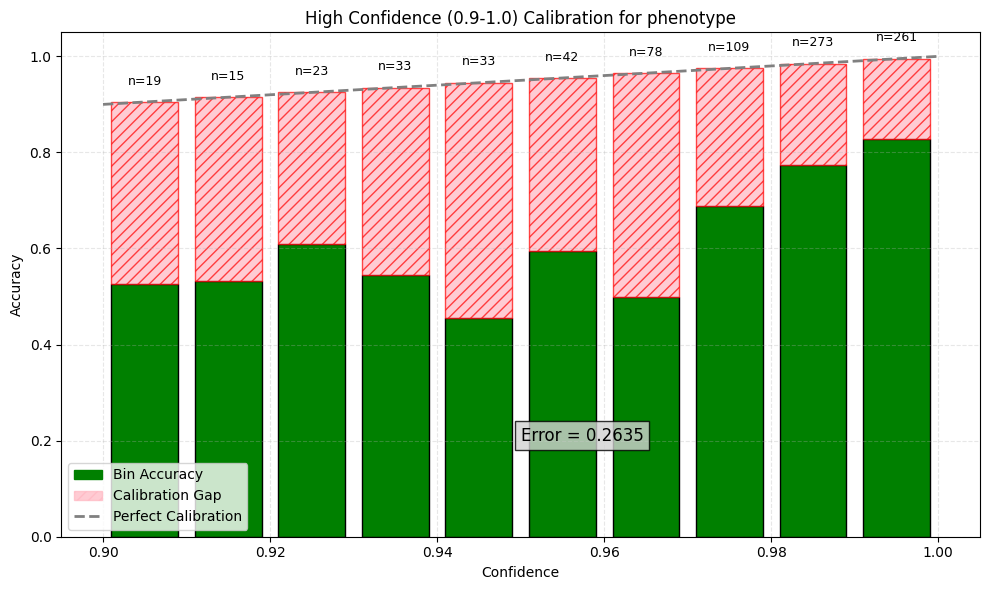

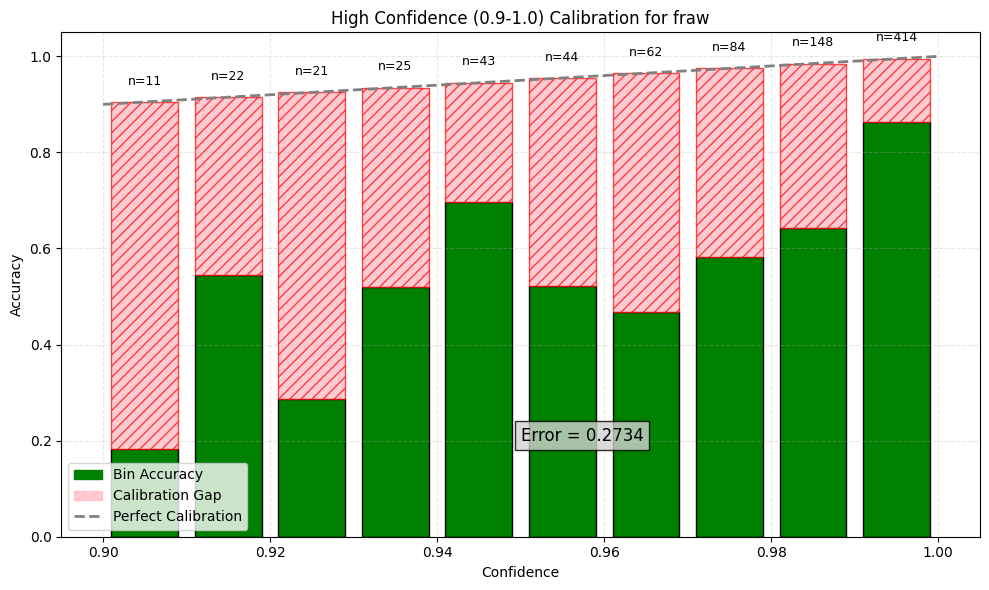

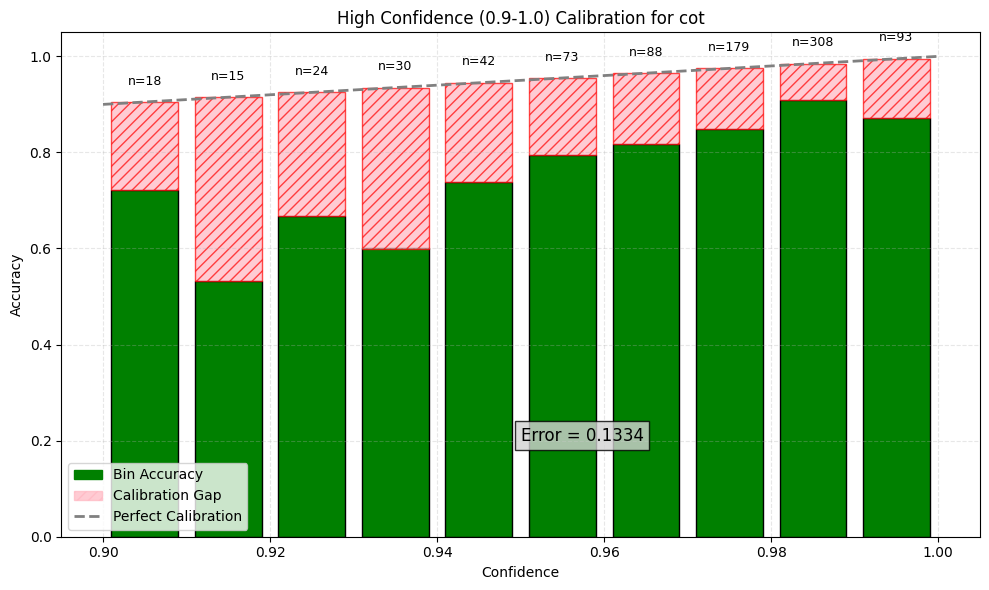

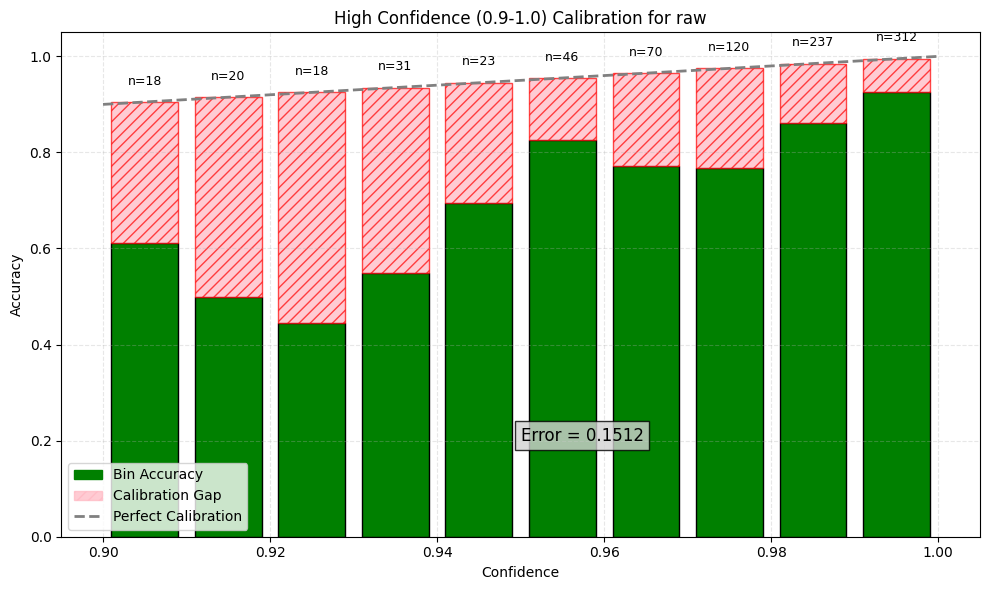

In [11]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jsonlines
from pathlib import Path

DATA_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt"
folder_path = Path(DATA_PATH)
all_files = [file for file in folder_path.rglob('*') if file.is_file()]

def clean_answer(answer):
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"
    else:
        return None

def cal_acc(answer, ground_truth):
    if answer == ground_truth:
        return 1
    else:
        return 0

def normalize_uncertainty_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    
    if max_score == min_score:
        return [0.0 for _ in scores]
    
    return [(s - min_score) / (max_score - min_score) for s in scores]

def calculate_confusion_matrix(predictions, ground_truths):
    confusion_matrix = [0, 0, 0, 0]
    
    for pred, truth in zip(predictions, ground_truths):
        if pred == "YES" and truth == "YES":
            confusion_matrix[3] += 1
        elif pred == "NO" and truth == "NO":
            confusion_matrix[0] += 1
        elif pred == "YES" and truth == "NO":
            confusion_matrix[1] += 1
        elif pred == "NO" and truth == "YES":
            confusion_matrix[2] += 1
    
    return confusion_matrix

def create_high_confidence_plot(uncertainty_scores, accuracies, model_name):
    confidence_scores = normalize_uncertainty_scores(uncertainty_scores)
    
    detailed_bin_edges = np.linspace(0.9, 1.0, 11)
    detailed_bin_centers = (detailed_bin_edges[:-1] + detailed_bin_edges[1:]) / 2
    
    bin_accuracies = np.zeros(len(detailed_bin_edges) - 1)
    bin_counts = np.zeros(len(detailed_bin_edges) - 1)
    
    for confidence, accuracy in zip(confidence_scores, accuracies):
        if 0.9 <= confidence <= 1.0:
            bin_idx = int((confidence - 0.9) * 100)
            if bin_idx >= 10:
                bin_idx = 9
            
            bin_accuracies[bin_idx] += accuracy
            bin_counts[bin_idx] += 1
    
    for i in range(len(bin_accuracies)):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
    
    perfect_calibration = detailed_bin_centers
    high_conf_samples = sum(bin_counts)
    if high_conf_samples > 0:
        error = np.sum(np.abs(bin_accuracies - perfect_calibration) * bin_counts) / high_conf_samples
    else:
        error = 0
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    width = 0.008
    for i in range(10):
        ax.bar(detailed_bin_centers[i], bin_accuracies[i], width=width, 
               color='green', edgecolor='black')
        
        if bin_accuracies[i] < detailed_bin_centers[i]:
            ax.bar(detailed_bin_centers[i], detailed_bin_centers[i] - bin_accuracies[i], 
                   bottom=bin_accuracies[i], width=width, color='lightpink', 
                   edgecolor='red', hatch='///', alpha=0.7)
        elif bin_accuracies[i] > detailed_bin_centers[i]:
            ax.bar(detailed_bin_centers[i], bin_accuracies[i] - detailed_bin_centers[i], 
                   bottom=detailed_bin_centers[i], width=width, color='lightpink',
                   edgecolor='red', hatch='///', alpha=0.7)
        
        ax.text(detailed_bin_centers[i], max(bin_accuracies[i] + 0.03, detailed_bin_centers[i] + 0.03), 
                f'n={int(bin_counts[i])}', ha='center', va='bottom', fontsize=9)
    
    ax.plot([0.9, 1.0], [0.9, 1.0], linestyle='--', linewidth=2, color='gray')
    
    ax.text(0.95, 0.2, f"Error = {error:.4f}", 
            bbox=dict(facecolor='lightgray', alpha=0.8), fontsize=12)
    
    ax.set_title(f'High Confidence (0.9-1.0) Calibration for {model_name}')
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(0.895, 1.005)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    green_patch = plt.Rectangle((0,0),1,1, color='green')
    pink_patch = plt.Rectangle((0,0),1,1, color='lightpink', alpha=0.7, hatch='///')
    ax.legend([green_patch, pink_patch, ax.get_lines()[0]], 
              ['Bin Accuracy', 'Calibration Gap', 'Perfect Calibration'])
    
    plt.tight_layout()
    # plt.savefig(f'high_confidence_plot_{model_name}.png')
    # print(f"High confidence plot saved as 'high_confidence_plot_{model_name}.png'")
    
    return error

def process_all_files():
    for file in all_files:
        file_path = os.path.join(folder_path, file)
        f_data = []
        file_uncertainties = []
        file_accuracies = []
        file_predictions = []
        file_ground_truths = []
        
        with jsonlines.open(file_path) as reader:
            for obj in reader:
                f_data.append(obj)
        
        for line in f_data:
            answer = line['answer']
            ground_truth = return_ground_truth(line['label'])
            
            if isinstance(answer, list):
                answer = answer[0]
            
            response = clean_answer(answer['output'])
            if response is None:
                continue
            
            logprobs = answer['logprobs']
            tokens = logprobs['tokens']
            
            response_prob = 0
            for tk in tokens:
                if response in tk.upper():
                    response_prob = logprobs['token_logprobs'][tokens.index(tk)]
            
            acc_score = cal_acc(response, ground_truth)
            
            file_uncertainties.append(response_prob)
            file_accuracies.append(acc_score)
            file_predictions.append(response)
            file_ground_truths.append(ground_truth)
        
        cm = calculate_confusion_matrix(file_predictions, file_ground_truths)
        tn, fp, fn, tp = cm
        
        filename = str(file).split("/")[-1]
        model_name = filename.split(".")[0]
        print(f"\nModel: {model_name}")
        print("Confusion Matrix:")
        print(f"{'':10s}| Predicted NO | Predicted YES |")
        print(f"{'-'*40}")
        print(f"Actual NO  | {tn:11d} | {fp:13d} |")
        print(f"Actual YES | {fn:11d} | {tp:13d} |")
        
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print("\nMetrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        high_conf_error = create_high_confidence_plot(file_uncertainties, file_accuracies, model_name)
        print(f"High Confidence Calibration Error: {high_conf_error:.4f}")

if __name__ == "__main__":
    process_all_files()

In [36]:
import jsonlines

GENE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/gene.jsonl"
PHENOTYPE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/phenotype.jsonl"
RAW_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl"

def clean_answer(answer):
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"
    else:
        return None

def read_file_predictions(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            answer = obj['answer']
            ground_truth = return_ground_truth(obj['label'])
            
            drug_name = obj.get('drug_name')
            disease_name = obj.get('disease_name')
            
            if isinstance(answer, list):
                answer = answer[0]
            
            response = clean_answer(answer['output'])
            if response is None:
                continue
            
            is_correct = response == ground_truth
            
            data.append({
                'drug_name': drug_name,
                'disease_name': disease_name,
                'prediction': response,
                'ground_truth': ground_truth,
                'is_correct': is_correct
            })
    
    return data

def create_model_comparison_matrix(data1, data2, name1, name2):
    common_samples = []
    
    data1_dict = {(item['drug_name'], item['disease_name']): item for item in data1}
    data2_dict = {(item['drug_name'], item['disease_name']): item for item in data2}
    
    common_keys = set(data1_dict.keys()) & set(data2_dict.keys())
    
    for common_key in common_keys:
        common_samples.append({
            'drug_name': common_key[0],
            'disease_name': common_key[1],
            name1: data1_dict[common_key],
            name2: data2_dict[common_key]
        })
    
    matrix = {
        "CORRECT_CORRECT": 0,
        "CORRECT_INCORRECT": 0,
        "INCORRECT_CORRECT": 0,
        "INCORRECT_INCORRECT": 0
    }
    
    for sample in common_samples:
        model1_result = "CORRECT" if sample[name1]['is_correct'] else "INCORRECT"
        model2_result = "CORRECT" if sample[name2]['is_correct'] else "INCORRECT"
        key = f"{model1_result}_{model2_result}"
        matrix[key] += 1
    
    total = len(common_samples)
    print(f"\n=== {name1} vs {name2} Comparison Matrix (Correctness) ===")
    print(f"Total common samples: {total}")
    print()
    print(f"{' ':15s} | {name2} CORRECT | {name2} INCORRECT |")
    print(f"{'-'*50}")
    print(f"{name1} CORRECT    | {matrix['CORRECT_CORRECT']:13d} | {matrix['CORRECT_INCORRECT']:16d} |")
    print(f"{name1} INCORRECT  | {matrix['INCORRECT_CORRECT']:13d} | {matrix['INCORRECT_INCORRECT']:16d} |")
    
    agreement = matrix['CORRECT_CORRECT'] + matrix['INCORRECT_INCORRECT']
    disagreement = matrix['CORRECT_INCORRECT'] + matrix['INCORRECT_CORRECT']
    
    model1_correct = matrix['CORRECT_CORRECT'] + matrix['CORRECT_INCORRECT']
    model2_correct = matrix['CORRECT_CORRECT'] + matrix['INCORRECT_CORRECT']
    
    print(f"\nAgreement: {agreement} samples ({agreement/total*100:.2f}%)")
    print(f"Disagreement: {disagreement} samples ({disagreement/total*100:.2f}%)")
    print(f"{name1} correct: {model1_correct} samples ({model1_correct/total*100:.2f}%)")
    print(f"{name2} correct: {model2_correct} samples ({model2_correct/total*100:.2f}%)")
    
    b = matrix['CORRECT_INCORRECT']
    c = matrix['INCORRECT_CORRECT']
    
    if b + c > 0:
        mcnemar = ((abs(b - c) - 1)**2) / (b + c)
        print(f"\nMcNemar's test statistic: {mcnemar:.4f}")
        print("(If > 3.84, difference is statistically significant at p < 0.05)")
    
    return matrix

def main():
    try:
        print("Reading data files...")
        gene_data = read_file_predictions(GENE_PATH)
        phenotype_data = read_file_predictions(PHENOTYPE_PATH)
        raw_data = read_file_predictions(RAW_PATH)
        
        print(f"Gene samples: {len(gene_data)}")
        print(f"Phenotype samples: {len(phenotype_data)}")
        print(f"Raw samples: {len(raw_data)}")
        
        gene_correct = sum(1 for item in gene_data if item['is_correct'])
        phenotype_correct = sum(1 for item in phenotype_data if item['is_correct'])
        raw_correct = sum(1 for item in raw_data if item['is_correct'])
        
        print(f"\nGene correct: {gene_correct}/{len(gene_data)} ({gene_correct/len(gene_data)*100:.2f}%)")
        print(f"Phenotype correct: {phenotype_correct}/{len(phenotype_data)} ({phenotype_correct/len(phenotype_data)*100:.2f}%)")
        print(f"Raw correct: {raw_correct}/{len(raw_data)} ({raw_correct/len(raw_data)*100:.2f}%)")
        
        gene_raw_matrix = create_model_comparison_matrix(gene_data, raw_data, "Gene", "Raw")
        phenotype_raw_matrix = create_model_comparison_matrix(phenotype_data, raw_data, "Phenotype", "Raw")
        gene_phenotype_matrix = create_model_comparison_matrix(gene_data, phenotype_data, "Gene", "Phenotype")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

Reading data files...
Gene samples: 1000
Phenotype samples: 1000
Raw samples: 1000

Gene correct: 599/1000 (59.90%)
Phenotype correct: 685/1000 (68.50%)
Raw correct: 776/1000 (77.60%)

=== Gene vs Raw Comparison Matrix (Correctness) ===
Total common samples: 1000

                | Raw CORRECT | Raw INCORRECT |
--------------------------------------------------
Gene CORRECT    |           516 |               83 |
Gene INCORRECT  |           260 |              141 |

Agreement: 657 samples (65.70%)
Disagreement: 343 samples (34.30%)
Gene correct: 599 samples (59.90%)
Raw correct: 776 samples (77.60%)

McNemar's test statistic: 90.3090
(If > 3.84, difference is statistically significant at p < 0.05)

=== Phenotype vs Raw Comparison Matrix (Correctness) ===
Total common samples: 1000

                | Raw CORRECT | Raw INCORRECT |
--------------------------------------------------
Phenotype CORRECT    |           606 |               79 |
Phenotype INCORRECT  |           170 |            

Reading data files...
Gene samples: 1000
Phenotype samples: 1000
Raw samples: 1000

=== Gene vs Raw Analysis ===
Total matched samples: 1000
Gene correct, Raw incorrect: 83
Gene incorrect, Raw correct: 260
Plot saved as 'Gene_vs_Raw_confidence_distribution.png'

Example questions where models disagreed:

Gene correct, Raw incorrect examples:
Q: None
  Drug: Trolnitrate, Disease: orthostatic hypotension
  Gene prediction: NO (correct, confidence: -0.1172)
  Raw prediction: YES (incorrect, confidence: -0.8175)

Q: None
  Drug: Trolnitrate, Disease: constipation disorder
  Gene prediction: NO (correct, confidence: -0.1119)
  Raw prediction: YES (incorrect, confidence: -1.0647)

Q: None
  Drug: Auranofin, Disease: Sjogren syndrome
  Gene prediction: NO (correct, confidence: -3.9669)
  Raw prediction: YES (incorrect, confidence: -0.4631)

Q: None
  Drug: Calcium gluconate, Disease: hyperparathyroidism
  Gene prediction: NO (correct, confidence: -0.8270)
  Raw prediction: YES (incorrect, con

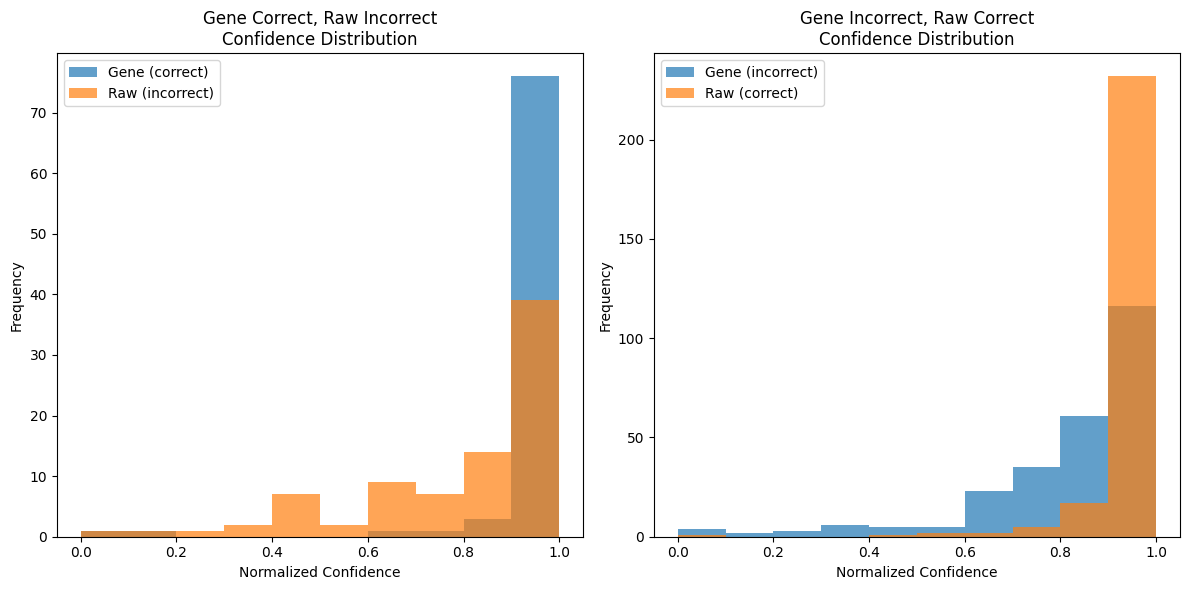

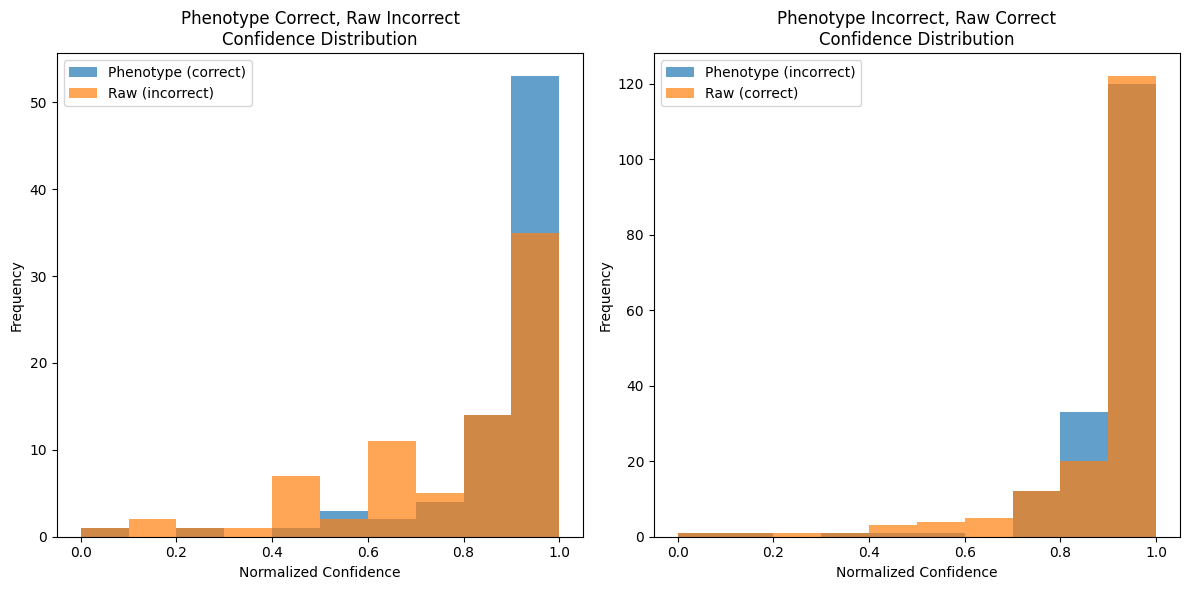

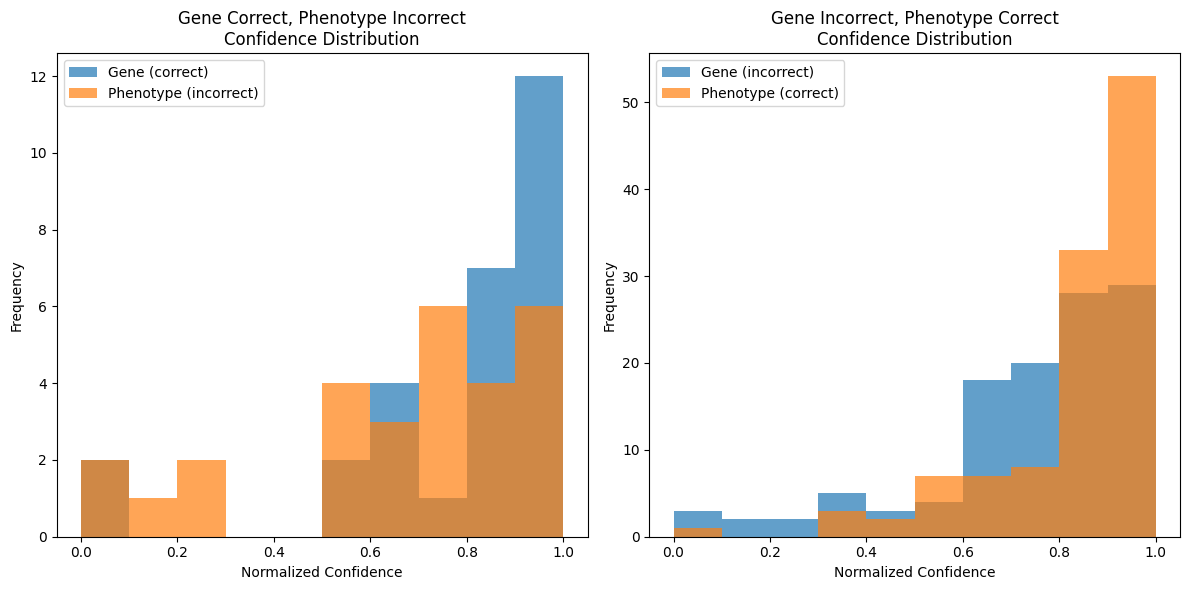

In [37]:
import jsonlines
import numpy as np
import matplotlib.pyplot as plt

GENE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/gene.jsonl"
PHENOTYPE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/phenotype.jsonl"
RAW_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl"

def clean_answer(answer):
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"
    else:
        return None

def normalize_uncertainty_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    
    if max_score == min_score:
        return [0.0 for _ in scores]
    
    return [(s - min_score) / (max_score - min_score) for s in scores]

def read_file_data(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            answer = obj['answer']
            ground_truth = return_ground_truth(obj['label'])
            
            drug_name = obj.get('drug_name')
            disease_name = obj.get('disease_name')
            
            if isinstance(answer, list):
                answer = answer[0]
            
            response = clean_answer(answer['output'])
            if response is None:
                continue
            
            logprobs = answer['logprobs']
            tokens = logprobs['tokens']
            
            response_prob = 0
            for tk in tokens:
                if response in tk.upper():
                    response_prob = logprobs['token_logprobs'][tokens.index(tk)]
            
            is_correct = response == ground_truth
            
            data.append({
                'drug_name': drug_name,
                'disease_name': disease_name,
                'question': obj.get('question', None),
                'prediction': response,
                'ground_truth': ground_truth,
                'is_correct': is_correct,
                'confidence': response_prob
            })
    
    return data

def find_model_disagreements(model1_data, model2_data, name1, name2):
    matched_samples = []
    
    model1_dict = {(item['drug_name'], item['disease_name']): item for item in model1_data}
    model2_dict = {(item['drug_name'], item['disease_name']): item for item in model2_data}
    
    common_keys = set(model1_dict.keys()) & set(model2_dict.keys())
    
    for key in common_keys:
        item1 = model1_dict[key]
        item2 = model2_dict[key]
        
        if item1['ground_truth'] == item2['ground_truth']:
            matched_samples.append({
                'drug_name': key[0],
                'disease_name': key[1],
                name1: item1,
                name2: item2
            })
    
    model1_correct_model2_incorrect = []
    
    for sample in matched_samples:
        if sample[name1]['is_correct'] and not sample[name2]['is_correct']:
            model1_correct_model2_incorrect.append(sample)
    
    model1_incorrect_model2_correct = []
    
    for sample in matched_samples:
        if not sample[name1]['is_correct'] and sample[name2]['is_correct']:
            model1_incorrect_model2_correct.append(sample)
    
    return {
        'all_matched': matched_samples,
        'model1_correct_model2_incorrect': model1_correct_model2_incorrect,
        'model1_incorrect_model2_correct': model1_incorrect_model2_correct
    }

def analyze_confidence_distribution(model1_data, model2_data, name1, name2):
    disagreements = find_model_disagreements(model1_data, model2_data, name1, name2)
    
    model1_correct_model2_wrong_confidence1 = [sample[name1]['confidence'] for sample in disagreements['model1_correct_model2_incorrect']]
    model1_correct_model2_wrong_confidence2 = [sample[name2]['confidence'] for sample in disagreements['model1_correct_model2_incorrect']]
    
    model1_wrong_model2_correct_confidence1 = [sample[name1]['confidence'] for sample in disagreements['model1_incorrect_model2_correct']]
    model1_wrong_model2_correct_confidence2 = [sample[name2]['confidence'] for sample in disagreements['model1_incorrect_model2_correct']]
    
    if model1_correct_model2_wrong_confidence1:
        model1_correct_model2_wrong_confidence1_norm = normalize_uncertainty_scores(model1_correct_model2_wrong_confidence1)
        model1_correct_model2_wrong_confidence2_norm = normalize_uncertainty_scores(model1_correct_model2_wrong_confidence2)
    else:
        model1_correct_model2_wrong_confidence1_norm = []
        model1_correct_model2_wrong_confidence2_norm = []
        
    if model1_wrong_model2_correct_confidence1:
        model1_wrong_model2_correct_confidence1_norm = normalize_uncertainty_scores(model1_wrong_model2_correct_confidence1)
        model1_wrong_model2_correct_confidence2_norm = normalize_uncertainty_scores(model1_wrong_model2_correct_confidence2)
    else:
        model1_wrong_model2_correct_confidence1_norm = []
        model1_wrong_model2_correct_confidence2_norm = []
    
    print(f"\n=== {name1} vs {name2} Analysis ===")
    print(f"Total matched samples: {len(disagreements['all_matched'])}")
    print(f"{name1} correct, {name2} incorrect: {len(disagreements['model1_correct_model2_incorrect'])}")
    print(f"{name1} incorrect, {name2} correct: {len(disagreements['model1_incorrect_model2_correct'])}")
    
    if model1_correct_model2_wrong_confidence1_norm:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.hist(model1_correct_model2_wrong_confidence1_norm, bins=10, alpha=0.7, label=f"{name1} (correct)")
        plt.hist(model1_correct_model2_wrong_confidence2_norm, bins=10, alpha=0.7, label=f"{name2} (incorrect)")
        plt.title(f"{name1} Correct, {name2} Incorrect\nConfidence Distribution")
        plt.xlabel('Normalized Confidence')
        plt.ylabel('Frequency')
        plt.legend()
        
        if model1_wrong_model2_correct_confidence1_norm:
            plt.subplot(1, 2, 2)
            plt.hist(model1_wrong_model2_correct_confidence1_norm, bins=10, alpha=0.7, label=f"{name1} (incorrect)")
            plt.hist(model1_wrong_model2_correct_confidence2_norm, bins=10, alpha=0.7, label=f"{name2} (correct)")
            plt.title(f"{name1} Incorrect, {name2} Correct\nConfidence Distribution")
            plt.xlabel('Normalized Confidence')
            plt.ylabel('Frequency')
            plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'{name1}_vs_{name2}_confidence_distribution.png')
        print(f"Plot saved as '{name1}_vs_{name2}_confidence_distribution.png'")
    
    print("\nExample questions where models disagreed:")
    
    max_examples = min(5, len(disagreements['model1_correct_model2_incorrect']))
    if max_examples > 0:
        print(f"\n{name1} correct, {name2} incorrect examples:")
        for i in range(max_examples):
            sample = disagreements['model1_correct_model2_incorrect'][i]
            drug = sample['drug_name']
            disease = sample['disease_name']
            question = sample[name1].get('question', f"Drug: {drug}, Disease: {disease}")
            conf1 = sample[name1]['confidence']
            conf2 = sample[name2]['confidence']
            print(f"Q: {question}")
            print(f"  Drug: {drug}, Disease: {disease}")
            print(f"  {name1} prediction: {sample[name1]['prediction']} (correct, confidence: {conf1:.4f})")
            print(f"  {name2} prediction: {sample[name2]['prediction']} (incorrect, confidence: {conf2:.4f})")
            print()
    
    max_examples = min(5, len(disagreements['model1_incorrect_model2_correct']))
    if max_examples > 0:
        print(f"\n{name1} incorrect, {name2} correct examples:")
        for i in range(max_examples):
            sample = disagreements['model1_incorrect_model2_correct'][i]
            drug = sample['drug_name']
            disease = sample['disease_name']
            question = sample[name1].get('question', f"Drug: {drug}, Disease: {disease}")
            conf1 = sample[name1]['confidence']
            conf2 = sample[name2]['confidence']
            print(f"Q: {question}")
            print(f"  Drug: {drug}, Disease: {disease}")
            print(f"  {name1} prediction: {sample[name1]['prediction']} (incorrect, confidence: {conf1:.4f})")
            print(f"  {name2} prediction: {sample[name2]['prediction']} (correct, confidence: {conf2:.4f})")
            print()
    
    return disagreements

def main():
    try:
        print("Reading data files...")
        gene_data = read_file_data(GENE_PATH)
        phenotype_data = read_file_data(PHENOTYPE_PATH)
        raw_data = read_file_data(RAW_PATH)
        
        print(f"Gene samples: {len(gene_data)}")
        print(f"Phenotype samples: {len(phenotype_data)}")
        print(f"Raw samples: {len(raw_data)}")
        
        gene_raw_disagreements = analyze_confidence_distribution(gene_data, raw_data, "Gene", "Raw")
        phenotype_raw_disagreements = analyze_confidence_distribution(phenotype_data, raw_data, "Phenotype", "Raw")
        gene_phenotype_disagreements = analyze_confidence_distribution(gene_data, phenotype_data, "Gene", "Phenotype")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [39]:
import jsonlines
import numpy as np

GENE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/gene.jsonl"
RAW_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl"

def clean_answer(answer):
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"
    else:
        return None

def read_file_data(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            answer = obj['answer']
            ground_truth = return_ground_truth(obj['label'])
            
            if isinstance(answer, list):
                answer = answer[0]
            
            response = clean_answer(answer['output'])
            if response is None:
                continue
            
            logprobs = answer['logprobs']
            tokens = logprobs['tokens']
            
            response_prob = 0
            for tk in tokens:
                if response in tk.upper():
                    response_prob = logprobs['token_logprobs'][tokens.index(tk)]
            
            is_correct = response == ground_truth
            
            data.append({
                'id': obj.get('id', None),
                'question': obj.get('question', None),
                'prediction': response,
                'ground_truth': ground_truth,
                'is_correct': is_correct,
                'confidence': response_prob
            })
    
    return data

def analyze_higher_confidence_cases(gene_data, raw_data):
    matched_samples = []
    
    min_length = min(len(gene_data), len(raw_data))
    for i in range(min_length):
        if gene_data[i]['ground_truth'] == raw_data[i]['ground_truth']:
            matched_samples.append({
                'index': i,
                'gene': gene_data[i],
                'raw': raw_data[i]
            })
    
    print(f"Total matched samples: {len(matched_samples)}")
    
    gene_higher_confidence = []
    for sample in matched_samples:
        if sample['gene']['confidence'] > sample['raw']['confidence']:
            gene_higher_confidence.append(sample)
    
    print(f"Samples where Gene confidence > Raw confidence: {len(gene_higher_confidence)}")
    
    both_correct = 0
    both_incorrect = 0
    gene_correct_raw_incorrect = 0
    gene_incorrect_raw_correct = 0
    
    for sample in gene_higher_confidence:
        gene_correct = sample['gene']['is_correct']
        raw_correct = sample['raw']['is_correct']
        
        if gene_correct and raw_correct:
            both_correct += 1
        elif not gene_correct and not raw_correct:
            both_incorrect += 1
        elif gene_correct and not raw_correct:
            gene_correct_raw_incorrect += 1
        elif not gene_correct and raw_correct:
            gene_incorrect_raw_correct += 1
    
    total_higher_confidence = len(gene_higher_confidence)
    
    print("\nIn samples where Gene confidence > Raw confidence:")
    print(f"Both correct: {both_correct} ({both_correct/total_higher_confidence*100:.2f}%)")
    print(f"Both incorrect: {both_incorrect} ({both_incorrect/total_higher_confidence*100:.2f}%)")
    print(f"Gene correct but Raw incorrect: {gene_correct_raw_incorrect} ({gene_correct_raw_incorrect/total_higher_confidence*100:.2f}%)")
    print(f"Gene incorrect but Raw correct: {gene_incorrect_raw_correct} ({gene_incorrect_raw_correct/total_higher_confidence*100:.2f}%)")
    
    if gene_correct_raw_incorrect > 0:
        confidence_diffs = []
        for sample in gene_higher_confidence:
            if sample['gene']['is_correct'] and not sample['raw']['is_correct']:
                diff = sample['gene']['confidence'] - sample['raw']['confidence']
                confidence_diffs.append(diff)
        
        avg_diff = sum(confidence_diffs) / len(confidence_diffs)
        print(f"\nAverage confidence difference in samples where Gene is correct but Raw is incorrect: {avg_diff:.4f}")
    
    return {
        'total_matched': len(matched_samples),
        'gene_higher_confidence': total_higher_confidence,
        'both_correct': both_correct,
        'both_incorrect': both_incorrect,
        'gene_correct_raw_incorrect': gene_correct_raw_incorrect,
        'gene_incorrect_raw_correct': gene_incorrect_raw_correct
    }

def main():
    try:
        print("Reading data files...")
        gene_data = read_file_data(GENE_PATH)
        raw_data = read_file_data(RAW_PATH)
        
        print(f"Gene samples: {len(gene_data)}")
        print(f"Raw samples: {len(raw_data)}")
        
        results = analyze_higher_confidence_cases(gene_data, raw_data)
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Reading data files...
Gene samples: 1000
Raw samples: 1000
Total matched samples: 1000
Samples where Gene confidence > Raw confidence: 405

In samples where Gene confidence > Raw confidence:
Both correct: 174 (42.96%)
Both incorrect: 102 (25.19%)
Gene correct but Raw incorrect: 57 (14.07%)
Gene incorrect but Raw correct: 72 (17.78%)

Average confidence difference in samples where Gene is correct but Raw is incorrect: 0.7590


In [16]:
import jsonlines
import numpy as np

PHENOTYPE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/phenotype.jsonl"
RAW_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl"

def clean_answer(answer):
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"
    else:
        return None

def read_file_data(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            answer = obj['answer']
            ground_truth = return_ground_truth(obj['label'])
            
            if isinstance(answer, list):
                answer = answer[0]
            
            response = clean_answer(answer['output'])
            if response is None:
                continue
            
            logprobs = answer['logprobs']
            tokens = logprobs['tokens']
            
            response_prob = 0
            for tk in tokens:
                if response in tk.upper():
                    response_prob = logprobs['token_logprobs'][tokens.index(tk)]
            
            is_correct = response == ground_truth
            
            data.append({
                'id': obj.get('id', None),
                'question': obj.get('question', None),
                'prediction': response,
                'ground_truth': ground_truth,
                'is_correct': is_correct,
                'confidence': response_prob
            })
    
    return data

def analyze_higher_confidence_cases(phenotype_data, raw_data):
    matched_samples = []
    
    min_length = min(len(phenotype_data), len(raw_data))
    for i in range(min_length):
        if phenotype_data[i]['ground_truth'] == raw_data[i]['ground_truth']:
            matched_samples.append({
                'index': i,
                'phenotype': phenotype_data[i],
                'raw': raw_data[i]
            })
    
    print(f"Total matched samples: {len(matched_samples)}")
    
    phenotype_higher_confidence = []
    for sample in matched_samples:
        if sample['phenotype']['confidence'] > sample['raw']['confidence']:
            phenotype_higher_confidence.append(sample)
    
    print(f"Samples where Phenotype confidence > Raw confidence: {len(phenotype_higher_confidence)}")
    
    both_correct = 0
    both_incorrect = 0
    phenotype_correct_raw_incorrect = 0
    phenotype_incorrect_raw_correct = 0
    
    for sample in phenotype_higher_confidence:
        phenotype_correct = sample['phenotype']['is_correct']
        raw_correct = sample['raw']['is_correct']
        
        if phenotype_correct and raw_correct:
            both_correct += 1
        elif not phenotype_correct and not raw_correct:
            both_incorrect += 1
        elif phenotype_correct and not raw_correct:
            phenotype_correct_raw_incorrect += 1
        elif not phenotype_correct and raw_correct:
            phenotype_incorrect_raw_correct += 1
    
    total_higher_confidence = len(phenotype_higher_confidence)
    
    print("\nIn samples where Phenotype confidence > Raw confidence:")
    print(f"Both correct: {both_correct} ({both_correct/total_higher_confidence*100:.2f}%)")
    print(f"Both incorrect: {both_incorrect} ({both_incorrect/total_higher_confidence*100:.2f}%)")
    print(f"Phenotype correct but Raw incorrect: {phenotype_correct_raw_incorrect} ({phenotype_correct_raw_incorrect/total_higher_confidence*100:.2f}%)")
    print(f"Phenotype incorrect but Raw correct: {phenotype_incorrect_raw_correct} ({phenotype_incorrect_raw_correct/total_higher_confidence*100:.2f}%)")
    
    if phenotype_correct_raw_incorrect > 0:
        confidence_diffs = []
        for sample in phenotype_higher_confidence:
            if sample['phenotype']['is_correct'] and not sample['raw']['is_correct']:
                diff = sample['phenotype']['confidence'] - sample['raw']['confidence']
                confidence_diffs.append(diff)
        
        avg_diff = sum(confidence_diffs) / len(confidence_diffs)
        print(f"\nAverage confidence difference in samples where Phenotype is correct but Raw is incorrect: {avg_diff:.4f}")
    
    return {
        'total_matched': len(matched_samples),
        'phenotype_higher_confidence': total_higher_confidence,
        'both_correct': both_correct,
        'both_incorrect': both_incorrect,
        'phenotype_correct_raw_incorrect': phenotype_correct_raw_incorrect,
        'phenotype_incorrect_raw_correct': phenotype_incorrect_raw_correct
    }

def main():
    try:
        print("Reading data files...")
        phenotype_data = read_file_data(PHENOTYPE_PATH)
        raw_data = read_file_data(RAW_PATH)
        
        print(f"Phenotype samples: {len(phenotype_data)}")
        print(f"Raw samples: {len(raw_data)}")
        
        results = analyze_higher_confidence_cases(phenotype_data, raw_data)
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Reading data files...
Phenotype samples: 1000
Raw samples: 1000
Total matched samples: 1000
Samples where Phenotype confidence > Raw confidence: 420

In samples where Phenotype confidence > Raw confidence:
Both correct: 213 (50.71%)
Both incorrect: 98 (23.33%)
Phenotype correct but Raw incorrect: 55 (13.10%)
Phenotype incorrect but Raw correct: 54 (12.86%)

Average confidence difference in samples where Phenotype is correct but Raw is incorrect: 0.7462


In [35]:
import jsonlines
from collections import defaultdict


GENE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/gene.jsonl"
PHENOTYPE_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/phenotype.jsonl"
RAW_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl"
COT_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/cot.jsonl"

def clean_answer(answer):
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"

def cal_acc(answer, ground_truth):
    if answer == ground_truth:
        acc_score = 1
    else:
        acc_score = 0
    return acc_score


def load_data():
    all_data = {}

    for prompt_type, file_path in [
        ('gene', GENE_PATH),
        ('phenotype', PHENOTYPE_PATH),
        ('raw', RAW_PATH),
        ('cot', COT_PATH)
    ]:
        with jsonlines.open(file_path) as reader:
            for item in reader:
                key = f"{item['drug_name'].lower()}_{item['disease_name'].lower()}"
                
                if key not in all_data:
                    all_data[key] = {
                        'drug_name': item['drug_name'],
                        'disease_name': item['disease_name'],
                        'ground_truth': return_ground_truth(item['label']),
                        'prompt_results': {}
                    }
                    
                answer = item['answer']
                if isinstance(answer, list):
                    answer = answer[0]
                
                response = clean_answer(answer['output'])
                if response is None:
                    continue
                
                logprobs = answer['logprobs']
                tokens = logprobs['tokens']
                response_prob = 0
                response_token_index = -1

                for i, tk in enumerate(tokens):
                    if response in tk.upper():
                        response_prob = logprobs['token_logprobs'][i]
                        response_token_index = i
                        break
                
                if response_prob is None or response_token_index == -1:
                    continue
                
                normalized_confidence = response_prob / (response_token_index + 1)

                all_data[key]['prompt_results'][prompt_type] = {
                    'response': response,
                    'confidence': normalized_confidence,
                    'acc': cal_acc(response, all_data[key]['ground_truth'])
                }
    
    return all_data

def ensemble_select(all_data):
    ensemble_results = []
    prompt_counts = defaultdict(int)
    
    for key, data in all_data.items():
        
        best_prompt = max(data['prompt_results'].items(), 
                         key=lambda x: x[1]['confidence'])[0]
        
        prompt_counts[best_prompt] += 1
        ensemble_results.append({
            'drug_name': data['drug_name'],
            'disease_name': data['disease_name'],
            'selected_prompt': best_prompt,
            'response': data['prompt_results'][best_prompt]['response'],
            'confidence': data['prompt_results'][best_prompt]['confidence'],
            'ground_truth': data['ground_truth'],
            'acc': data['prompt_results'][best_prompt]['acc']
        })
    
    return ensemble_results, prompt_counts


def calculate_metrics(ensemble_results, prompt_counts, all_data):
    ensemble_acc = sum(r['acc'] for r in ensemble_results) / len(ensemble_results) if ensemble_results else 0
    
    individual_accs = {}
    prompt_availability = defaultdict(int)
    
    for data in all_data.values():
        for prompt_type, result in data['prompt_results'].items():
            prompt_availability[prompt_type] += 1
            if prompt_type not in individual_accs:
                individual_accs[prompt_type] = []
            individual_accs[prompt_type].append(result['acc'])
    
    prompt_accs = {}
    for prompt_type, accs in individual_accs.items():
        if accs:
            prompt_accs[prompt_type] = sum(accs) / len(accs)
    
    print(f"Total unique drug-disease pairs: {len(all_data)}")
    print(f"Pairs with at least one prompt result: {len(ensemble_results)}")
    
    print("\nPrompt type availability:")
    for prompt_type in ['gene', 'phenotype', 'raw', 'cot']:
        print(f"  - {prompt_type}: {prompt_availability[prompt_type]} pairs")
    
    print("\nIndividual prompt type accuracies:")
    for prompt_type in ['gene', 'phenotype', 'raw', 'cot']:
        if prompt_type in prompt_accs:
            print(f"  - {prompt_type}: {prompt_accs[prompt_type]:.4f}")
    
    print("\nEnsemble accuracy (selecting highest confidence):")
    print(f"  - {ensemble_acc:.4f}")
    
    print("\nEnsemble method prompt type selection distribution:")
    for prompt_type in ['gene', 'phenotype', 'raw', 'cot']:
        count = prompt_counts[prompt_type]
        percentage = (count / len(ensemble_results)) * 100 if ensemble_results else 0
        print(f"  - {prompt_type}: {count} times ({percentage:.2f}%)")

def main():
    all_data = load_data()
    
    ensemble_results, prompt_counts = ensemble_select(all_data)

    calculate_metrics(ensemble_results, prompt_counts, all_data)

if __name__ == "__main__":
    main()

Total unique drug-disease pairs: 1000
Pairs with at least one prompt result: 1000

Prompt type availability:
  - gene: 1000 pairs
  - phenotype: 1000 pairs
  - raw: 1000 pairs
  - cot: 1000 pairs

Individual prompt type accuracies:
  - gene: 0.5990
  - phenotype: 0.6850
  - raw: 0.7760
  - cot: 0.7960

Ensemble accuracy (selecting highest confidence):
  - 0.7690

Ensemble method prompt type selection distribution:
  - gene: 225 times (22.50%)
  - phenotype: 230 times (23.00%)
  - raw: 444 times (44.40%)
  - cot: 101 times (10.10%)
